# Chorus Example: Running Sei predictions


## Installation Instructions (Reference)

If you haven't installed Chorus yet, follow these steps:

```bash
# 1. Clone the repository
git clone https://github.com/pinellolab/chorus.git
cd chorus

# 2. Create the main Chorus environment
mamba env create -f environment.yml
mamba activate chorus

# 3. Install Chorus package
pip install -e .

# 4. Set up the Sei environment
chorus setup --oracle sei

# 5. Download the reference genome
chorus genome download hg38
```

**Note**: 
- For this notebook, we assume Chorus is already installed.
- pyGenomeTracks is now included in the environment for advanced visualization!

## Setup and Imports

In [1]:
# Import required libraries
import chorus
from chorus.utils import get_genome, extract_sequence, download_gencode
from chorus.utils.visualization import visualize_chorus_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set up matplotlib for inline display
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Set up plotting with white background
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100  # Increase DPI for better quality

print("Chorus version:", chorus.__version__ if hasattr(chorus, '__version__') else "development")

Chorus version: 0.1.0


## 1. Setting up Reference Genome and Sei Oracle

In [2]:
# Download gene annotations
print("\nSetting up gene annotations...")
gtf_path = download_gencode(version='v48', annotation_type='basic')
print(f"Using annotations: {gtf_path}")

2025-12-11 12:21:13,066 - chorus.utils.annotations - INFO - Annotation file already exists: /home/penzard/pinellolab/chorus/annotations/gencode.v48.basic.annotation.gtf



Setting up gene annotations...
Using annotations: /home/penzard/pinellolab/chorus/annotations/gencode.v48.basic.annotation.gtf


In [3]:
# Get reference genome (auto-downloads if not present)
print("Setting up reference genome...")
genome_path = get_genome('hg38')
print(f"Using genome: {genome_path}")

# Create Enformer oracle with environment isolation
print("\nCreating Sei oracle...")
# For different configurations:
# - Force CPU: device='cpu'
# - Use specific GPU: device='cuda:0'
oracle = chorus.create_oracle(
    'sei',
    sliding_predict=True,
    use_environment=True,
    reference_fasta=str(genome_path),
    device="cuda:1"
)

# Load pre-trained model
print("\nLoading pre-trained Sei model...")
print("To force CPU usage: device='cpu'")
print("To disable timeout: export CHORUS_NO_TIMEOUT=1")
oracle.load_pretrained_model()
print("Model loaded successfully!")

2025-12-11 12:21:13,074 - chorus.core.base - INFO - Device set to: cuda:1
2025-12-11 12:21:13,094 - chorus.core.environment.manager - INFO - Found conda via CONDA_EXE: /home/penzard/conda/bin/conda
2025-12-11 12:21:13,095 - chorus.core.environment.manager - INFO - Found mamba at: /home/penzard/conda/bin/mamba


Setting up reference genome...
Using genome: /home/penzard/pinellolab/chorus/genomes/hg38.fa

Creating Sei oracle...


2025-12-11 12:21:16,796 - chorus.core.base - INFO - Using conda environment: chorus-sei
2025-12-11 12:21:16,798 - chorus.oracles.sei - INFO - Dowloading Sei model into /home/penzard/pinellolab/chorus/downloads/sei...
2025-12-11 12:21:16,799 - chorus.oracles.sei - INFO - Sei model archive is already downloaded!
2025-12-11 12:21:43,680 - chorus.oracles.sei - INFO - Sei model downloaded and extracted successfully!



Loading pre-trained Sei model...
To force CPU usage: device='cpu'
To disable timeout: export CHORUS_NO_TIMEOUT=1


2025-12-11 12:22:01,443 - chorus.oracles.sei - INFO - Sei model loaded successfully in environment!


Model loaded successfully!


## 2. Exploring Available Tracks

In [4]:
# List available assay types
assay_types = oracle.list_assay_types()
print(f"Available assay types ({len(assay_types)}):")
for i, assay in enumerate(assay_types[:20], 1):
    print(f"  {i:2d}. {assay}")
print(f"  ... and {len(assay_types) - 20} more")
print("\n" + "="*50 + "\n")

# List available cell types (show first 20 due to large number)
cell_types = oracle.list_cell_types()
print(f"Available cell types ({len(cell_types)}):")
for i, cell in enumerate(cell_types[:20], 1):
    print(f"  {i:2d}. {cell}")
print(f"  ... and {len(cell_types) - 20} more")
print("\n" + "="*50 + "\n")

# List available class types (show first 20 )
class_types = oracle.list_class_types()
print(f"Available class types ({len(class_types)}):")
for i, cl in enumerate(class_types[:20], 1):
    print(f"  {i:2d}. {cl}")
print(f"  ... and {len(class_types) - 20} more")
print("\n" + "="*50 + "\n")

# List available group types (show first 20 )
group_types = oracle.list_group_types()
print(f"Available groups ({len(group_types)}):")
for i, group in enumerate(group_types, 1):
    print(f"  {i:2d}. {group}")


Available assay types (1176):
   1. BTAF1
   2. EOMES
   3. EP300
   4. FOXH1
   5. FOXP1
   6. H2BK12ac
   7. H2BK15ac
   8. H2BK5ac
   9. H3K18ac
  10. H3K23me2
  11. H3K27ac
  12. H3K27me3
  13. H3K36me3
  14. H3K4ac
  15. H3K4me1
  16. H3K4me2
  17. H3K4me3
  18. H3K56ac
  19. H3K79me2
  20. H3K9ac
  ... and 1156 more


Available cell types (1742):
   1. HeLa_Epithelium_Cervix
   2. H9_Embryonic_Stem_Cell_Embryo
   3. Endothelial_Cell_Artery
   4. LS174T_Epithelium_Colon
   5. HCT-116_Colon
   6. HEK293_Epithelium_Embryonic_Kidney
   7. HeLa-S3_Epithelium_Cervix
   8. HepG2_Epithelium_Liver
   9. hES_I3_Embryonic_Stem_Cell_Embryo
  10. Hs68_Fibroblast_Foreskin
  11. Satellite_Cells_Muscle
  12. HUES48_Embryonic_Stem_Cell_Embryo
  13. HUES6_Embryonic_Stem_Cell_Embryo
  14. HUES64_Embryonic_Stem_Cell_Embryo
  15. Endothelial_Cell_Umbilical_Vein
  16. IB4_Lymphocyte_Blood
  17. IMR90_Fibroblast_Lung
  18. iPS_4_iPSC
  19. iPS_A1_iPSC
  20. iPS_A6_iPSC
  ... and 1722 more


Available c

## Example: Select specific sequence classes or targets


In [5]:
classes = oracle.select_classes(pats=[[None, 'Promoter'],
                             [None, 'Enhancer']])

In [6]:
classes

['CA#E1@Stem cell@Enhancer@5',
 'CA#E2@Multi-tissue@Enhancer@6',
 'CA#E3@Brain / Melanocyte@Enhancer@7',
 'CA#E4@Multi-tissue@Enhancer@9',
 'CA#E5@B-cell-like@Enhancer@12',
 'CA#E6@Weak epithelial@Enhancer@13',
 'CA#E7@Monocyte / Macrophage@Enhancer@16',
 'CA#E8@Weak multi-tissue@Enhancer@17',
 'CA#P@Promoter@Promoter@25',
 'CA#E9@Liver / Intestine@Enhancer@26',
 'CA#E10@Brain@Enhancer@30',
 'CA#E11@T-cell@Enhancer@36',
 'CA#E12@Erythroblast-like@Enhancer@38']

In [7]:
targets = oracle.select_targets(pats=[['H3K4me1', 'HepG2'],
                             ['H3K4me1', 'K562']])

In [8]:
targets

['TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35420',
 'TA#HepG2_Epithelium_Liver@H3K4me1@ID:36651',
 'TA#HepG2_Epithelium_Liver@H3K4me1@ID:45298',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:45407',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:45415',
 'TA#HepG2_Epithelium_Liver@H3K4me1@ID:51255',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:55733',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:55734',
 'TA#K562_human_erythroleukemic_cell_line@H3K4me1@ID:68375',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:8461',
 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:8462',
 'TA#HepG2_Hepatocellular_Carcinoma@H3K4me1@Roadmap',
 'TA#K562@H3K4me1@Roadmap']

## Example A: Wild-type Sequence Prediction


In [9]:
# Define GATA1 TSS region
gata1_region = "chrX:48777634-48790694"
print(f"Analyzing wild-type region: {gata1_region}")
print("This region contains the GATA1 transcription start site\n")

# Extract sequence information
wt_seq = extract_sequence(gata1_region, str(genome_path))
print(f"Region length: {len(wt_seq):,} bp")
print(f"GC content: {(wt_seq.count('G') + wt_seq.count('C')) / len(wt_seq) * 100:.1f}%")

Analyzing wild-type region: chrX:48777634-48790694
This region contains the GATA1 transcription start site

Region length: 13,061 bp
GC content: 47.2%


In [10]:
assay_ids = targets + classes
track_ids =  targets[0:2] + classes[0:2]

In [11]:
# Make predictions for wild-type sequence
print("Making predictions using specific track identifiers...")
print(f"Track IDs: {track_ids}")
wt_results = oracle.predict(
    ('chrX', 48726820, 48841508),
    track_ids  # Using specific track IDs
)

# Print statistics
for track_id, predictions in wt_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {predictions.shape}")
    print(f"  Mean signal: {np.mean(predictions):.4f}")
    print(f"  Max signal: {np.max(predictions):.4f}")

Making predictions using specific track identifiers...
Track IDs: ['TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027', 'TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417', 'CA#E1@Stem cell@Enhancer@5', 'CA#E2@Multi-tissue@Enhancer@6']


2025-12-11 12:23:07,796 - chorus.core.result - WARNING - Unknown implementation 'H3K4me1'. Available: ATAC, CAGE, CHIP, DNASE, LentiMPRA, RNA
2025-12-11 12:23:07,798 - chorus.core.result - WARNING - Unknown implementation 'H3K4me1'. Available: ATAC, CAGE, CHIP, DNASE, LentiMPRA, RNA
2025-12-11 12:23:07,799 - chorus.core.result - WARNING - Unknown implementation 'Stem cell'. Available: ATAC, CAGE, CHIP, DNASE, LentiMPRA, RNA
2025-12-11 12:23:07,801 - chorus.core.result - WARNING - Unknown implementation 'Multi-tissue'. Available: ATAC, CAGE, CHIP, DNASE, LentiMPRA, RNA



TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:2027:
  Shape: (896,)
  Mean signal: 0.0294
  Max signal: 0.7547

TA#K562_Erythroblast_Bone_Marrow@H3K4me1@ID:35417:
  Shape: (896,)
  Mean signal: 0.0106
  Max signal: 0.5693

CA#E1@Stem cell@Enhancer@5:
  Shape: (896,)
  Mean signal: 1.4956
  Max signal: 22.6800

CA#E2@Multi-tissue@Enhancer@6:
  Shape: (896,)
  Mean signal: 1.6170
  Max signal: 26.0001


In [12]:
import coolbox
from coolbox.api import *

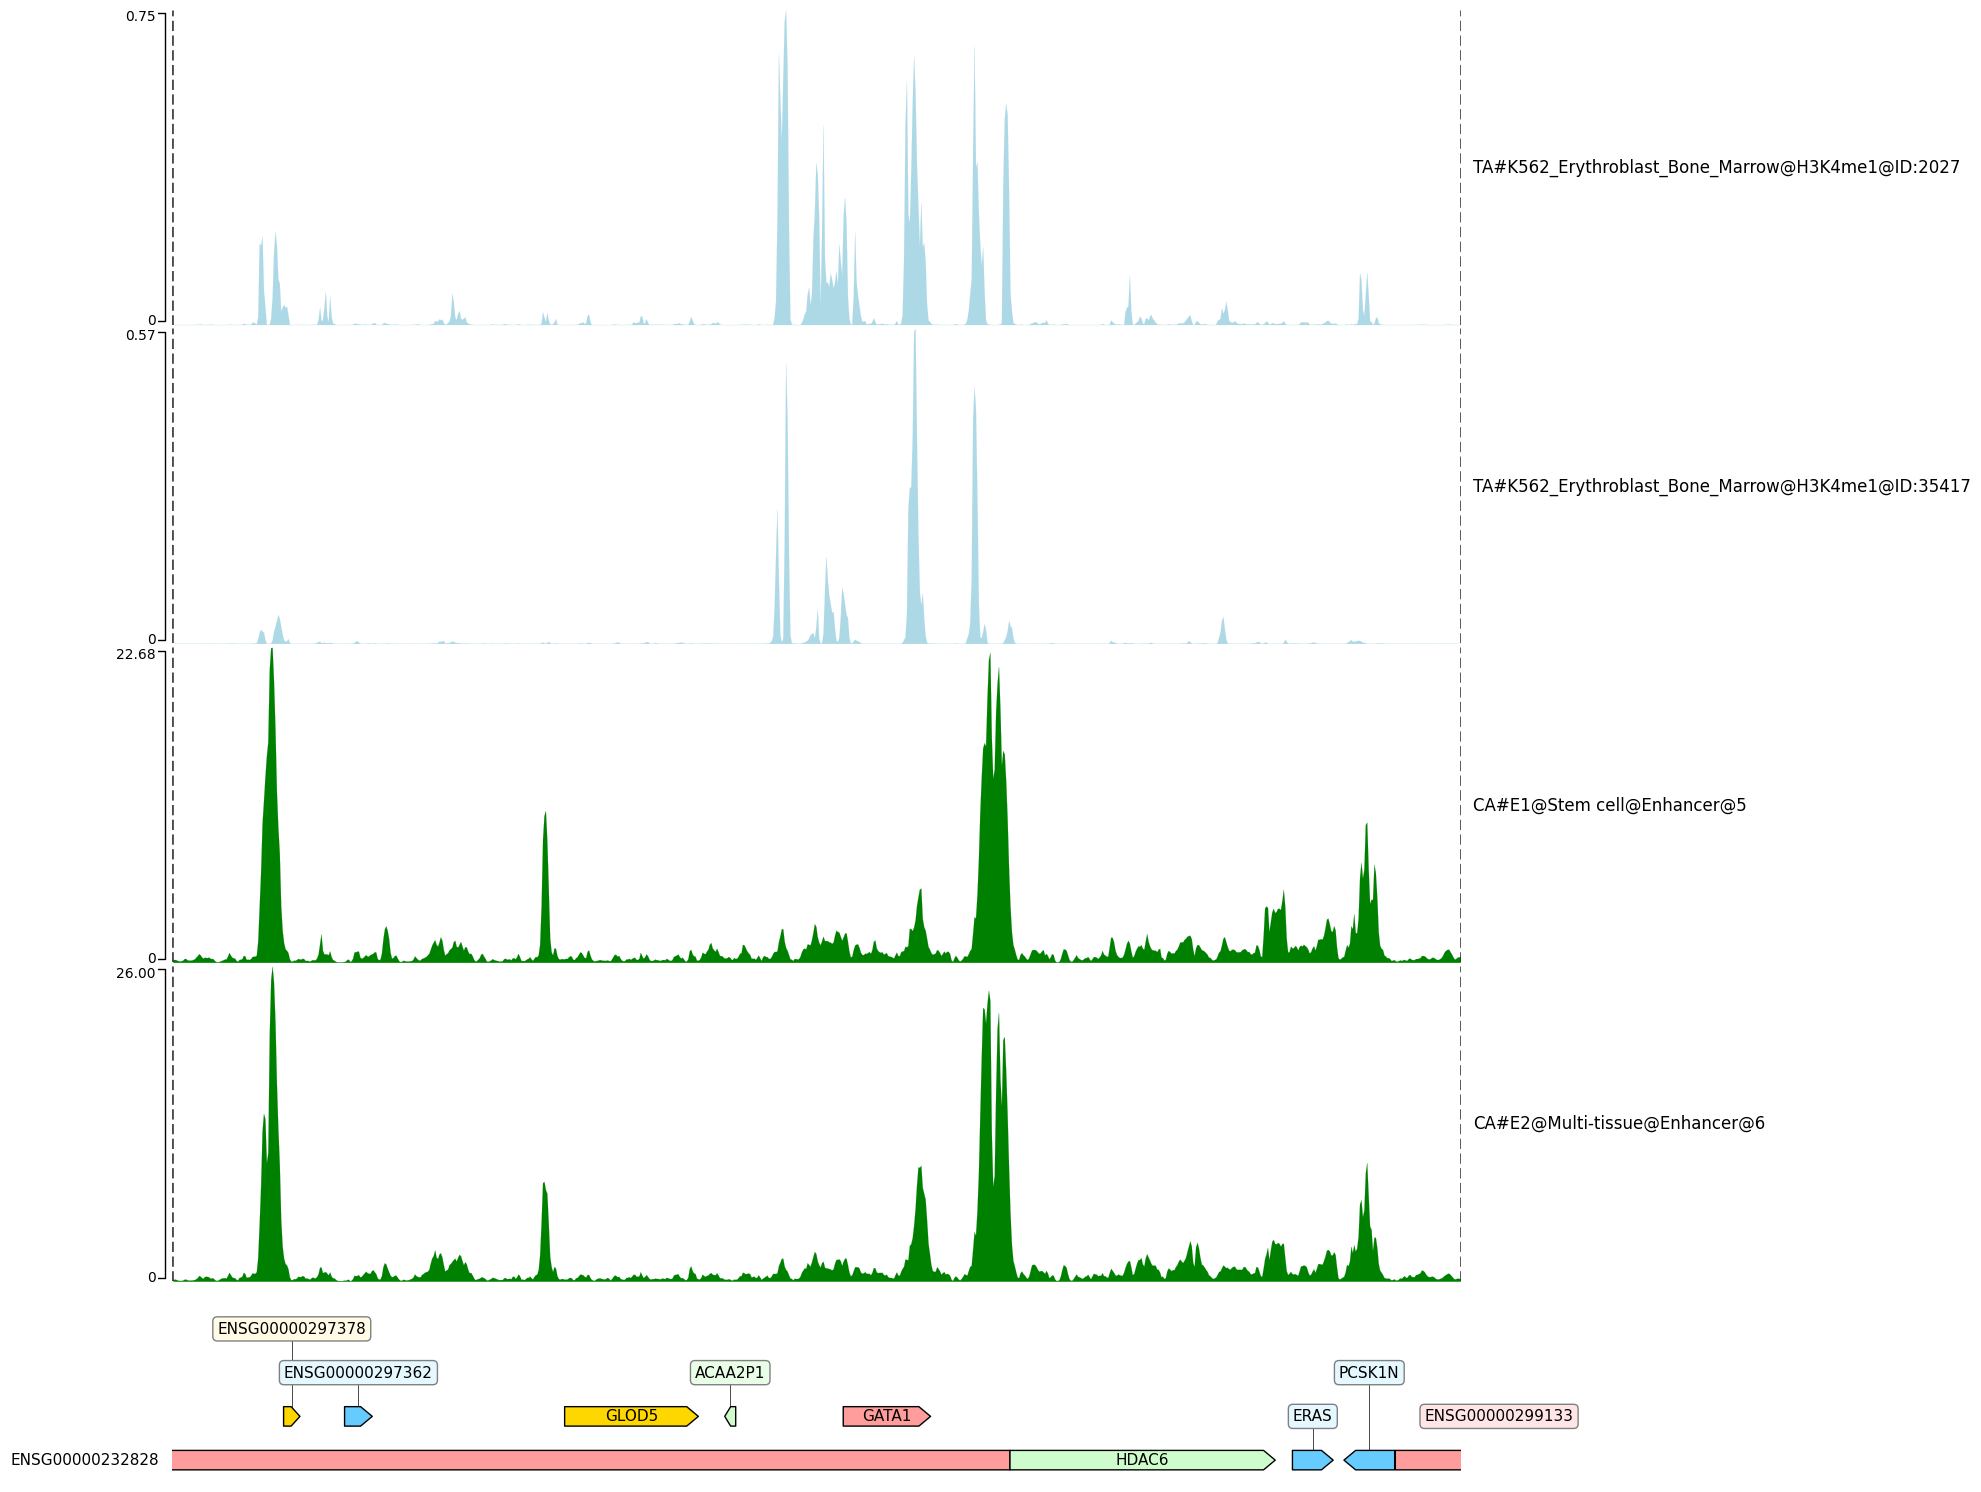

In [13]:
preds = list(wt_results.values())

frame = preds[0].get_coolbox_representation(add_xaxis=False, override_params={'color': 'lightblue'})   +\
        Spacer(0.1) + \
        preds[1].get_coolbox_representation(add_xaxis=False, override_params={'color': 'lightblue'})   +\
                Spacer(0.1) + \
        preds[2].get_coolbox_representation(add_xaxis=False, override_params={'color': 'green'})   +\
                Spacer(0.1) + \
        preds[3].get_coolbox_representation(add_xaxis=False, override_params={'color': 'green'})   +\
                Spacer(0.1) + \
        GTF(str(gtf_path)) + TrackHeight(5)
    
frame.plot('chrX:48726820-48841508') 